In [1]:
import scanpy as sc
import scvi
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder

Global seed set to 0


In [2]:
tox_adata = sc.read_h5ad("/project/gilad/jpopp/cellcipher/data/Tox2-full/single_cell_objects/filtered_pflog1ppfnorm.hvg.umap_embedding.h5ad")
tox_adata_raw = sc.read_h5ad("/project/gilad/jpopp/cellcipher/data/Tox2-full/single_cell_objects/filtered.h5ad")

In [3]:
assert tox_adata.obs.index.equals(tox_adata_raw.obs.index)

In [7]:
sc.tl.leiden(tox_adata, resolution=1.25, key_added='leiden')

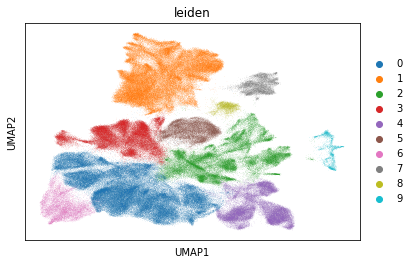

In [4]:
sc.pl.umap(tox_adata, color='leiden')

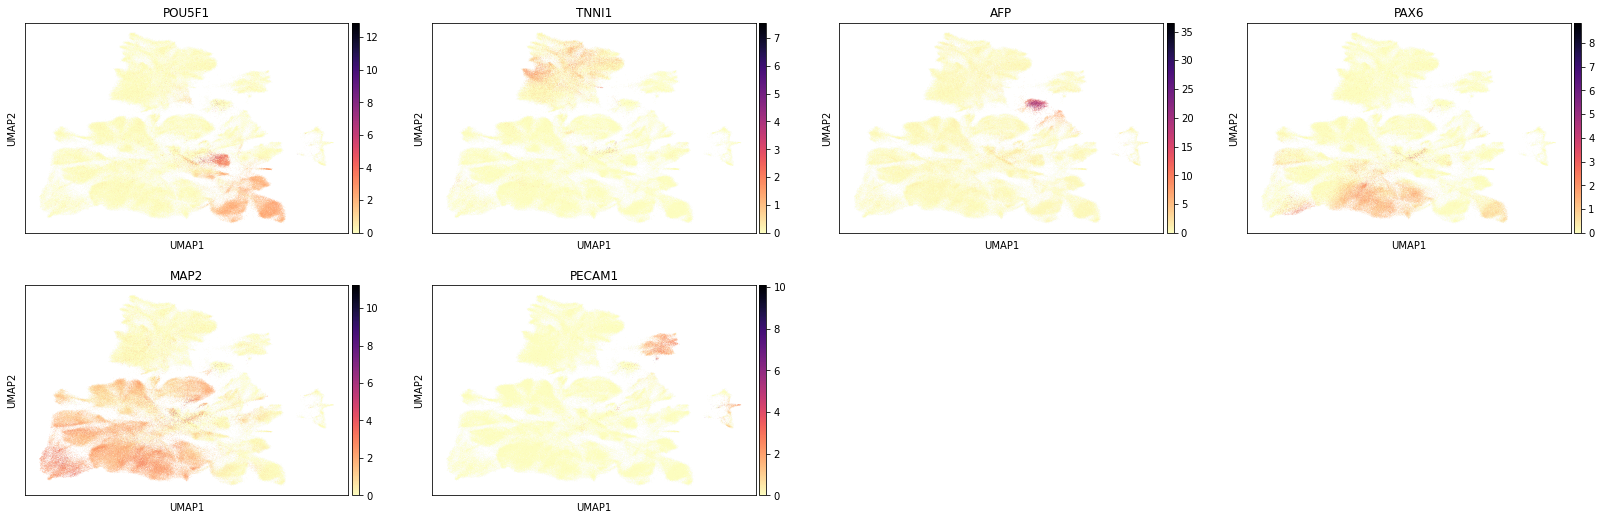

In [6]:
sc.pl.umap(tox_adata, color=['POU5F1', 'TNNI1', 'AFP', 'PAX6', 'MAP2', 'PECAM1'], color_map='magma_r')

In [7]:
celltype_labels = {0: 'earlyecto', 
                   1:'mesoderm', 
                   2: 'pluripotent', 
                   3: 'neuron', 
                   4: 'pluripotent', 
                   5: 'neuron',
                  6: 'neuron',
                  7: 'endothelial',
                  8: 'endoderm',
                  9: 'endothelial'}

In [8]:
tox_adata.obs['celltype'] = [celltype_labels[int(c)] for c in tox_adata.obs['leiden']]

In [9]:
tox_adata.obs[['treatment']].value_counts()

treatment
Rof          55623
Sit          53264
Ome          47880
Per          45587
Rim          43556
Ace          42510
Dox          41813
Nef          37993
dtype: int64

In [10]:
treatment_map = {
    'Rof': 'Rofecoxib',
    'Sit': 'Sitaxsentan',
    'Ome': 'Omeprazole',
    'Per': 'Perhexilene',
    'Rim': 'Rimonabant',
    'Ace': 'Acetaminophen',
    'Dox': 'Doxycycline',
    'Nef': 'Nefazodone'
}

In [11]:
tox_adata.obs['treatment_name'] = [treatment_map[t] for t in tox_adata.obs['treatment']]

In [12]:
cell_subset = tox_adata.obs[['sample_id', 'donor_id', 'celltype']]
cell_subset['pseudobulk_sample'] = cell_subset['sample_id'].astype(str) + '_' + cell_subset['donor_id'].astype(str) + '_' + cell_subset['celltype'].astype(str)

/tmp/jobs/31672186/ipykernel_95249/782936707.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_subset['pseudobulk_sample'] = cell_subset['sample_id'].astype(str) + '_' + cell_subset['donor_id'].astype(str) + '_' + cell_subset['celltype'].astype(str)


In [13]:
onehot = OneHotEncoder(sparse=True).fit_transform(cell_subset[['pseudobulk_sample']])
onehot

<368226x468 sparse matrix of type '<class 'numpy.float64'>'
	with 368226 stored elements in Compressed Sparse Row format>

In [14]:
pseudobulk_sum = tox_adata_raw.X.transpose() * onehot

In [15]:
pseudobulk_sum = pd.DataFrame(pseudobulk_sum.todense(),
                              index=tox_adata_raw.var_names, 
                              columns=cell_subset['pseudobulk_sample'].astype("category").cat.categories).astype(int)

In [16]:
pseudobulk_sum.to_csv("/project/gilad/jpopp/cellcipher/data/Tox2-full/pseudobulk_expression.tsv", sep="\t")

In [17]:
treatment_dict = tox_adata.obs[['sample_id', 'treatment', 'treatment_name']].drop_duplicates()

In [18]:
treatment_dict

,sample_id,treatment,treatment_name
cell,,,
AAACCCAAGAAGGTAG-1,YG-KR-16s-Tox2-05-5-Dox,Dox,Doxycycline
AAACCCAAGTAAATGC-2,YG-KR-16s-Tox2-06-6-Dox,Dox,Doxycycline
AAACCCAAGAGAGCAA-3,YG-KR-16s-Tox2-10-10-Per,Per,Perhexilene
AAACCCAAGAGTCACG-4,YG-KR-16s-Tox2-03-3-Ace,Ace,Acetaminophen
AAACCCAAGAACTTCC-5,YG-KR-16s-Tox2-04-4-Ace,Ace,Acetaminophen
AAACCCAAGATTCGCT-6,YG-KR-16s-Tox2-12-12-Rof,Rof,Rofecoxib
AAACCCAAGTACTGTC-7,YG-KR-16s-Tox2-11-11-Rof,Rof,Rofecoxib
AAACCCAAGAGGTGCT-8,YG-KR-16s-Tox2-16-16-Sit,Sit,Sitaxsentan
AAACCCAAGCCTATCA-9,YG-KR-16s-Tox2-07-7-Rim,Rim,Rimonabant


In [19]:
treatment_dict.to_csv("/project/gilad/jpopp/cellcipher/data/Tox2-full/treatment_dict.tsv", sep="\t", index=False)